# Sarsa

## cliffwalk environment

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm  # tqdm是显示循环进度条的库


class CliffWalkingEnv:
    def __init__(self, ncol, nrow):
        self.nrow = nrow
        self.ncol = ncol
        self.x = 0  # 记录当前智能体位置的横坐标
        self.y = self.nrow - 1  # 记录当前智能体位置的纵坐标

    def step(self, action):  # 外部调用这个函数来改变当前位置
        # 4种动作, change[0]:上, change[1]:下, change[2]:左, change[3]:右。坐标系原点(0,0)
        # 定义在左上角
        change = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        self.x = min(self.ncol - 1, max(0, self.x + change[action][0]))
        self.y = min(self.nrow - 1, max(0, self.y + change[action][1]))
        next_state = self.y * self.ncol + self.x
        reward = -1
        done = False
        if self.y == self.nrow - 1 and self.x > 0:  # 下一个位置在悬崖或者目标
            done = True
            if self.x != self.ncol - 1:
                reward = -100
        return next_state, reward, done

    def reset(self):  # 回归初始状态,坐标轴原点在左上角
        self.x = 0
        self.y = self.nrow - 1
        return self.y * self.ncol + self.x

## Sarsa

In [21]:
class Sarsa:
    """Sarsa算法"""
    def __init__(self, n_col, n_row, alpha, gamma, epsilon, n_action=4):
        self.Q_table = np.zeros([n_col * n_row, n_action])
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.n_action = n_action

    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
        return action

    def update(self, a0, s0, a1, s1, r):
        self.Q_table[s0][a0] = self.Q_table[s0][a0] - self.alpha * (self.Q_table[s0][a0] - (r + self.gamma * self.Q_table[s1][a1]))

    def best_action(self, state): # 用于打印策略
        Q_max = np.max(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action):  # 若两个动作的价值一样,都会记录下来
            if self.Q_table[state, i] == Q_max:
                a[i] = 1
        return a

Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 7163.38it/s, episode=500, return=-18.900, num_return=500.000, i=9, i_episode=49]


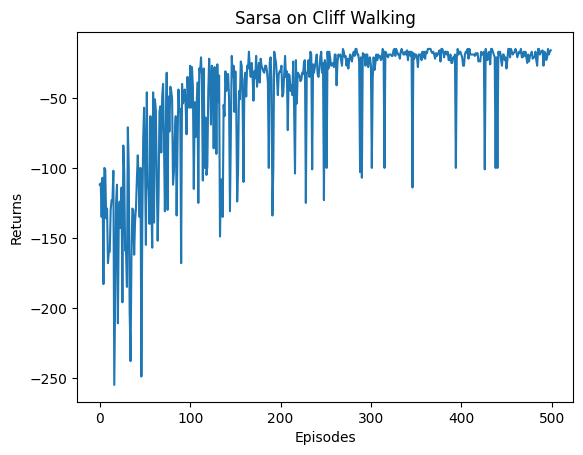

In [22]:
ncol = 12
nrow = 4
env = CliffWalkingEnv(ncol, nrow)
np.random.seed(0)
epsilon = 0.1
alpha = 0.1
gamma = 0.9
agent = Sarsa(n_row=nrow, n_col=ncol, alpha=alpha, gamma=gamma, epsilon=epsilon)
num_episodes = 500  

return_list = [] 
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc="Iteration %d" % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            state = env.reset()
            action = agent.take_action(state)
            done = False
            while not done:
                next_state, reward, done = env.step(action=action)
                episode_return += reward
                next_action = agent.take_action(state=next_state)
                agent.update(a0=action, s0=state, a1=next_action, s1=next_state, r=reward)
                state = next_state
                action = next_action
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0: # 每一个iteration打印一下这个iteration的平均回报
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:]),
                    'num_return':
                    '%.3f' % len(return_list),
                    'i':
                    '%d' % i,
                    'i_episode':
                    '%d' % i_episode
                })
            pbar.update(1)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Sarsa on {}'.format('Cliff Walking'))
plt.show()

In [23]:
def print_agent(agent, env, action_meaning, disaster=[], end=[]):
    for i in range(env.nrow):
        for j in range(env.ncol):
            if (i * env.ncol + j) in disaster:
                print('****', end=' ')
            elif (i * env.ncol + j) in end:
                print('EEEE', end=' ')
            else:
                a = agent.best_action(i * env.ncol + j)
                pi_str = ''
                for k in range(len(action_meaning)):
                    pi_str += action_meaning[k] if a[k] > 0 else 'o'
                print(pi_str, end=' ')
        print()


action_meaning = ['^', 'v', '<', '>']
print('Sarsa算法最终收敛得到的策略为：')
print_agent(agent, env, action_meaning, list(range(37, 47)), [47])

Sarsa算法最终收敛得到的策略为：
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo ooo> ^ooo ooo> ooo> ooo> ooo> ^ooo ^ooo ooo> ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 


## n-step Sarsa

In [24]:
class nstep_Sarsa:
    """ n步Sarsa算法 """
    def __init__(self, n, ncol, nrow, epsilon, alpha, gamma, n_action=4):
        self.Q_table = np.zeros([nrow * ncol, n_action])
        self.n_action = n_action
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.n = n  # 采用n步Sarsa算法
        self.state_list = []  # 保存之前的状态
        self.action_list = []  # 保存之前的动作
        self.reward_list = []  # 保存之前的奖励

    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
        return action

    def best_action(self, state):  # 用于打印策略
        Q_max = np.max(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action):
            if self.Q_table[state, i] == Q_max:
                a[i] = 1
        return a

    def update(self, s0, a0, r, s1, a1, done):
        self.state_list.append(s0)
        self.action_list.append(a0)
        self.reward_list.append(r)
        if len(self.state_list) == self.n:  # 若保存的数据可以进行n步更新
            G = self.Q_table[s1, a1]  # 得到Q(s_{t+n}, a_{t+n})
            for i in reversed(range(self.n)):
                G = self.gamma * G + self.reward_list[i]  # 不断向前计算每一步的回报
                # 如果到达终止状态,最后几步虽然长度不够n步,也将其进行更新
                if done and i > 0:
                    s = self.state_list[i]
                    a = self.action_list[i]
                    self.Q_table[s, a] += self.alpha * (G - self.Q_table[s, a])
            s = self.state_list.pop(0)  # 将需要更新的状态动作从列表中删除,下次不必更新
            a = self.action_list.pop(0)
            self.reward_list.pop(0)
            # n步Sarsa的主要更新步骤
            self.Q_table[s, a] += self.alpha * (G - self.Q_table[s, a])
        if done:  # 如果到达终止状态,即将开始下一条序列,则将列表全清空
            self.state_list = []
            self.action_list = []
            self.reward_list = []

Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 6268.58it/s, episode=500, return=-19.100]


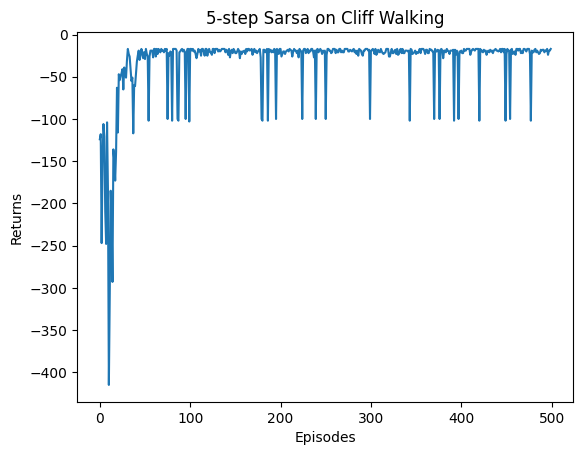

In [25]:
np.random.seed(0)
n_step = 5  # 5步Sarsa算法
alpha = 0.1
epsilon = 0.1
gamma = 0.9
agent = nstep_Sarsa(n_step, ncol, nrow, epsilon, alpha, gamma)
num_episodes = 500  # 智能体在环境中运行的序列的数量

return_list = []  # 记录每一条序列的回报
for i in range(10):  # 显示10个进度条
    #tqdm的进度条功能
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):  # 每个进度条的序列数
            episode_return = 0
            state = env.reset()
            action = agent.take_action(state)
            done = False
            while not done:
                next_state, reward, done = env.step(action)
                next_action = agent.take_action(next_state)
                episode_return += reward  # 这里回报的计算不进行折扣因子衰减
                agent.update(state, action, reward, next_state, next_action,
                             done)
                state = next_state
                action = next_action
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:  # 每10条序列打印一下这10条序列的平均回报
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('5-step Sarsa on {}'.format('Cliff Walking'))
plt.show()

## Q learning

In [31]:
class QLearning:
    """Qlearing算法"""
    def __init__(self, n_col, n_row, alpha, gamma, epsilon, n_action=4):
        self.Q_table = np.zeros([n_col * n_row, n_action])
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.n_action = n_action

    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
        return action

    def update(self, a0, s0, s1, r):
        self.Q_table[s0][a0] = self.Q_table[s0][a0] - self.alpha * (self.Q_table[s0][a0] - (r + self.gamma * self.Q_table[s1].max()))

    def best_action(self, state): # 用于打印策略
        Q_max = np.max(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action):  # 若两个动作的价值一样,都会记录下来
            if self.Q_table[state, i] == Q_max:
                a[i] = 1
        return a

Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 7167.79it/s, episode=500, return=-43.700, num_return=500.000, i=9, i_episode=49]


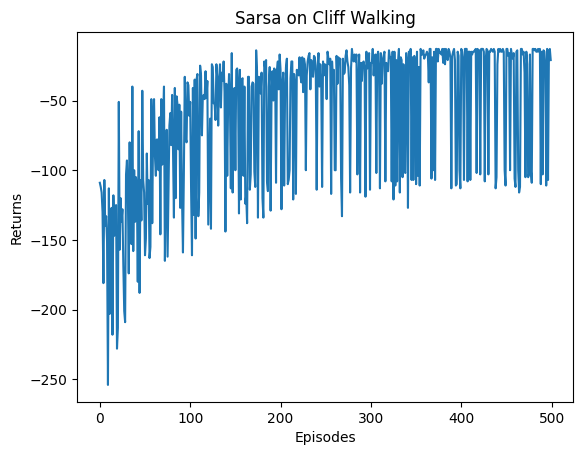

In [32]:
ncol = 12
nrow = 4
env = CliffWalkingEnv(ncol, nrow)
np.random.seed(0)
epsilon = 0.1
alpha = 0.1
gamma = 0.9
agent = QLearning(n_row=nrow, n_col=ncol, alpha=alpha, gamma=gamma, epsilon=epsilon)
num_episodes = 500  

return_list = [] 
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc="Iteration %d" % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            state = env.reset()
            action = agent.take_action(state)
            done = False
            while not done:
                action = agent.take_action(state)
                next_state, reward, done = env.step(action=action)
                episode_return += reward
                agent.update(a0=action, s0=state, s1=next_state, r=reward)
                state = next_state
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0: # 每一个iteration打印一下这个iteration的平均回报
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:]),
                    'num_return':
                    '%.3f' % len(return_list),
                    'i':
                    '%d' % i,
                    'i_episode':
                    '%d' % i_episode
                })
            pbar.update(1)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Sarsa on {}'.format('Cliff Walking'))
plt.show()

In [1]:
from utils import rl_utils

d:\Miniconda\envs\cs285\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
